# Lab 2 - Glødetråd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr

In [2]:
file = 'D:/Documents2/WorkspaceVScode/sebastjr/lab2data2.tsv'

# Definerer konstanter og generell data setup
sigma = 5.670374419 * 10**(-8)  # Stefan-Boltzmann konst. [W m^-2 K^-4]
R_0 = 0.23  # Lampe resistans ved rom temp. [Ohm]
R_R300K = [
    1.0, 1.43, 1.87, 2.34, 2.85, 3.36, 3.88, 4.41, 4.95, 5.48,
    6.03, 6.58, 7.14, 7.71, 8.28, 8.86, 9.44, 10.03, 10.63, 11.24,
    11.84, 12.46, 13.08, 13.72, 14.34, 14.99, 15.63, 16.29, 16.95,
    17.62, 18.28, 18.97, 19.66, 26.35
]
V = [] # Lampe spenning [V]
I = [] # Lampe strøm [A]
V_s = [] # Sensor spenning [mV]
Temp = np.linspace(300, 3600, len(R_R300K))  # Temperatur range i labhefte tabell 2 [K]
Temp_analytic = np.linspace(1000, 2200, 10)  # Analytisk temp. range [K]

# Stefan-Boltzmanns lov (log10)
def logj(t): # t gitt i log10
    return 4 * t + np.log10(sigma)

# Definerer funksjonen for bruk i ODR
def linear_model(B, x):
    return B[0] * x + B[1]

In [3]:
with open(file, 'r') as f:
    next(f) # Skipper første linje

    for line in f: # Går linje for linje og eksporterer data
            column = line.split('\t') # tsv fil - tab separerer data
            V.append(float(column[0])) # V
            I.append(float(column[1])) # A
            V_s.append(float(column[2])) # mV

# Gjør om liste til array
V = np.array(V)
I = np.array(I)
V_s = np.array(V_s)/1000
T_error = 50  # Absolutt temp usikkerhet [K]
V_error = 0.005/1000  # Absolutt spenning usikkerhet [V]

# Kalkulerer resistans og finner temp
R = V / I / R_0 
T = np.interp(R, R_R300K, Temp)

# Transformerer data til log10 skala
log_T = np.log10(T)
log_V_s = np.log10(V_s)

# Kalkulerer usikkerheter i log10 skala
log_T_error = T_error / (T * np.log(10))
log_V_s_error = V_error / (V_s * np.log(10))

# Initialiserer modellen og setter initialverdier
mydata = odr.Data(log_T, log_V_s, wd=log_T_error, we=log_V_s_error)
model = odr.Model(linear_model)
myodr = odr.ODR(mydata, model, beta0=[4.0, 0])

# Kjører ODR
myoutput = myodr.run()
slope, intercept = myoutput.beta

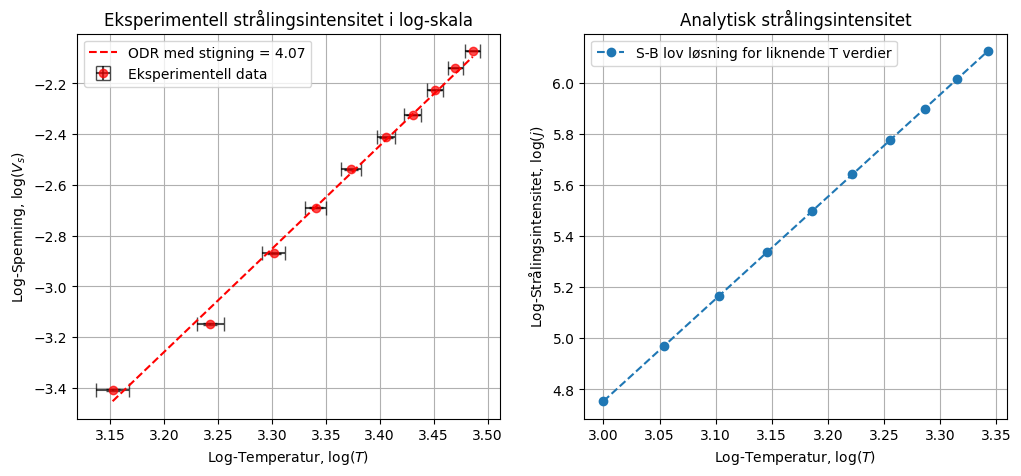

In [4]:
plt.figure(figsize=(12, 5))

# Eksperimentell data
plt.subplot(1, 2, 1)
plt.errorbar(log_T, log_V_s, xerr=log_T_error, yerr=log_V_s_error, color='red', marker='o',
             ls = ' ', capsize=5, capthick=1, ecolor='black', label='Eksperimentell data', alpha=0.7)
plt.plot(log_T, linear_model([slope, intercept], log_T), label = f'ODR med stigning = {round(slope, 2)}', color = 'r', ls = '--')
plt.xlabel('Log-Temperatur, $\log(T)$')
plt.ylabel('Log-Spenning, $\log(V_s)$')
plt.grid()
plt.legend()
plt.title('Eksperimentell strålingsintensitet i log-skala')

# Analytisk plott
plt.subplot(1, 2, 2)
plt.plot(np.log10(Temp_analytic), logj(np.log10(Temp_analytic)), label='S-B lov løsning for liknende T verdier', marker='o', linestyle='--')
plt.xlabel('Log-Temperatur, $\log(T)$')
plt.ylabel('Log-Strålingsintensitet, $\log(j)$')
plt.grid()
plt.legend()
plt.title('Analytisk strålingsintensitet')

# plt.savefig('eksperimentell.pdf', format = 'pdf', bbox_inches="tight")
plt.show()